In [54]:
from google.colab import files
uploaded = files.upload()

Saving covidRecife.csv to covidRecife (1).csv


In [70]:
# instalando as dependencias necessárias

!pip install mlflow optuna pyngrok fbprophet --quiet


In [75]:
# importando todas as bibliotecas que vamos utilizar no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from random import random
from fbprophet import Prophet
import mlflow
from pyngrok import ngrok
import optuna


In [76]:
# importando o dataset
# exportamos este dataset do projeto 1, entao os dados ja estão tratados
covidRecife = pd.read_csv(r'covidRecife.csv', encoding = "utf-8").dropna()
covidRecife = covidRecife.sort_values(by=['date'], ascending=True)
covidRecife.reset_index(inplace=True, drop=True)
covidRecife.head()

ParserError: ignored

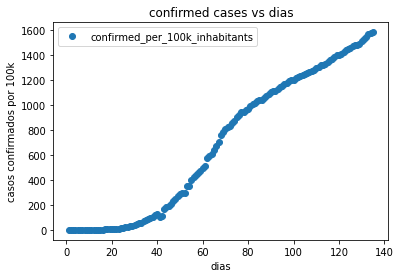

In [58]:
# olhando para o nosso problema, vamos tentar fazer predições nos números de casos confirmados por 100k habitantes em Recife
covidRecife.plot(x='order_for_place', y='confirmed_per_100k_inhabitants', style='o')
plt.title('confirmed cases vs dias')
plt.xlabel('dias')
plt.ylabel('casos confirmados por 100k')
plt.show()

In [59]:
# cria um experimento no mlflow pra cada algoritmo logar seus resultados

try:
    experiment_id_regression = mlflow.create_experiment(name="regression")
    experiment_id_prophet = mlflow.create_experiment(name="prophet")
    experiment_id_ES = mlflow.create_experiment(name="Exponential Smoothing")
    experiment_id_SES = mlflow.create_experiment(name="Simple Exponential Smoothing")

except:
    experiment_id_regression = mlflow.get_experiment_by_name(name="regression").experiment_id
    experiment_id_prophet = mlflow.get_experiment_by_name(name="prophet").experiment_id
    experiment_id_ES = mlflow.get_experiment_by_name(name="Exponential Smoothing").experiment_id
    experiment_id_SES = mlflow.get_experiment_by_name(name="Simple Exponential Smoothing").experiment_id


In [60]:
# dividimos o dataset em: 
#  train_valid -> será dividido dentro da função de cada modelo pois a maneira como cada um recebe os dados pode ser diferente
#                  e é usado para treinar e validar o modelo 
#  test -> usado para incrementar conjunto de teste no melhor algorítmo
size = int(len(covidRecife) * 0.8)
train_valid, test = covidRecife[0:size], covidRecife[size:len(covidRecife)]

In [61]:
# definimos cada modelo em uma função para que seja mais fácil usar o optuna mais adiante

# RandomForest Regressor

def randomForest_func(train_valid, n_estimators, min_samples_split, random_state ): 
  feature_cols = ['deaths', 'order_for_place', 'estimated_population_2019', 'death_rate']
  X = train_valid[feature_cols]
  X = train_valid[['deaths', 'order_for_place', 'estimated_population_2019', 'death_rate']]
  y = train_valid['confirmed_per_100k_inhabitants']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

  mlflow.sklearn.autolog()
  regressor = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=random_state)

  with mlflow.start_run(experiment_id=experiment_id_regression, run_name="randomForest") as run:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    squared_error = metrics.mean_squared_error(y_test, y_pred)
    root_error = np.sqrt(squared_error)
    
    mlflow.log_metric('Mean_Absolute_Error', metrics.mean_absolute_error(y_test, y_pred))
    mlflow.log_metric('Mean_Squared_Error', squared_error)
    mlflow.log_metric('Root_Mean_Squared_Error', root_error)
    mlflow.end_run()
    return np.float64(root_error)


In [62]:
# facebook prophet

def prophet_func(train_valid, changepoint_prior_scale, growth, changepoint_range):

  prophet_df = train_valid[['date','confirmed_per_100k_inhabitants']].reset_index()
  prophet_df.columns = ["index","ds", "y"]

  size = int(len(prophet_df) * 0.7)
  train, valid = prophet_df[0:size], prophet_df[size:len(prophet_df)]

  with mlflow.start_run(experiment_id=experiment_id_prophet, run_name="prophet") as run:
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, growth=growth, changepoint_range=changepoint_range)
    m.fit(train)
    periods = len(valid)
    pred = m.predict(m.make_future_dataframe(periods=periods))

    pred = pred['yhat'].iloc[len(train):]
    valid = valid['y']
  
    squared_error = metrics.mean_squared_error(valid, pred)
    absolute_error = metrics.mean_absolute_error(valid, pred)
    root_error = np.sqrt(squared_error)

    mlflow.log_metric('Mean_Absolute_Error', np.float64(absolute_error))
    mlflow.log_metric('Mean_Squared_Error', np.float64(squared_error))
    mlflow.log_metric('Root_Mean_Squared_Error', root_error)
    mlflow.log_param("periods", str(periods))
    mlflow.log_param("changepoint_prior_scale", str(changepoint_prior_scale))
    mlflow.log_param("growth", str(growth))
    mlflow.log_param("changepoint_range", str(changepoint_range))
    mlflow.end_run()
    return np.float64(root_error)

In [63]:
# Exponential Smoothing (ES) - root

def ES_func(df, smoothing_level, smoothing_seasonal):
	X = df['confirmed_per_100k_inhabitants'].values
	size = int(len(X) * 0.66)
	train, test = X[0:size], X[size:len(X)]

	with mlflow.start_run(experiment_id=experiment_id_ES, run_name="ES") as run:
		history = [x for x in train]
		predictions = list()
		for t in range(len(test)):
			model = ExponentialSmoothing(history)
			model_fit = model.fit(smoothing_level=smoothing_level, smoothing_seasonal=smoothing_seasonal)
			output = model_fit.predict(len(history), len(history))
			yhat = output[0]
			predictions.append(yhat)
			obs = test[t]
			history.append(obs)	 
	squared_error = metrics.mean_squared_error(test, predictions)
	root_error = np.sqrt(squared_error)
	mlflow.log_param("smoothing_level", str(smoothing_level))
	mlflow.log_metric('Mean_Absolute_Error', metrics.mean_absolute_error(test, predictions))
	mlflow.log_metric('Mean_Squared_Error', squared_error)
	mlflow.log_metric('Root_Mean_Squared_Error', root_error)
	mlflow.end_run()
	return np.float64(root_error)
 

In [64]:

# Simple Exponential Smoothing (SES)

def SES_func(df, smoothing_level, optimized):
	X = df['confirmed_per_100k_inhabitants'].values
	size = int(len(X) * 0.66)
	train, test = X[0:size], X[size:len(X)]

	with mlflow.start_run(experiment_id=experiment_id_SES, run_name="SES") as run:
		history = [x for x in train]
		predictions = list()
		for t in range(len(test)):
			model = SimpleExpSmoothing(history)
			model_fit = model.fit(smoothing_level=smoothing_level, optimized=optimized)
			output = model_fit.predict(len(history), len(history))
			yhat = output[0]
			predictions.append(yhat)
			obs = test[t]
			history.append(obs)	 
	squared_error = metrics.mean_squared_error(test, predictions)
	root_error = np.sqrt(squared_error)
	mlflow.log_param("smoothing_level", str(smoothing_level))
	mlflow.log_metric('Mean_Absolute_Error', metrics.mean_absolute_error(test, predictions))
	mlflow.log_metric('Mean_Squared_Error', squared_error)
	mlflow.log_metric('Root_Mean_Squared_Error', root_error)
	mlflow.end_run()
 
	return np.float64(root_error)
 

In [65]:
# executa a IU do mlflow em segundo plano e cria um tunel remoto usando ngrok para permitir o acesso a porta local
# com isso podemos ver a UI clicando no link printado abaixo
get_ipython().system_raw("mlflow ui --port 5000 &") 

ngrok.kill()

NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

INFO:pyngrok.process:Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.6/dist-packages/pyngrok/bin/ngrok
INFO:pyngrok.ngrok:Opening tunnel named: http-5000-b09d98fb-db90-409b-b5af-9c4a068f3924
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:17+0000 lvl=info msg="no configuration paths supplied"
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:17+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:17+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:17+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:18+0000 lvl=info msg="tunnel session started" obj=tunnels.session
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:18+0000 lvl=info msg="client session established" obj=csess id=2c0f4797b83f
INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:18+0000 l

MLflow Tracking UI: https://482abb701bc5.ngrok.io


INFO:pyngrok.process.ngrok:t=2020-11-17T01:45:18+0000 lvl=info msg=end pg=/api/tunnels id=d9a6734c10569e47 status=201 dur=30.014615ms


In [66]:
# usando optuna para encontrar o melhor conjunto de hiperparametros

def objective(trial):

    estimator_name = trial.suggest_categorical("predictor", ["randomForest", "ses", "prophet", "es"])

    root_error = 0
    if estimator_name == 'randomForest':
        n_estimators = trial.suggest_int("n_estimators", 1, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 6)
        random_state = trial.suggest_int("min_samples_split", 0, 3)

        root_error = randomForest_func(train_valid, n_estimators, min_samples_split, random_state)

    elif estimator_name == 'prophet':
        changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
        growth = trial.suggest_categorical("growth",['linear'])
        changepoint_range = trial.suggest_float("changepoint_range", 0.8, 0.95)

        root_error = prophet_func(train_valid, changepoint_prior_scale, growth, changepoint_range)

    elif estimator_name == 'es':
        smoothing_level = trial.suggest_float("smoothing_level", 0.0, 1.0)
        smoothing_seasonal = trial.suggest_float("smoothing_level", 0, 10)

        root_error = ES_func(train_valid, smoothing_level, smoothing_seasonal)

    elif estimator_name == 'ses':
        smoothing_level = trial.suggest_float("smoothing_level", 0.0, 1.0)
        optimized = trial.suggest_categorical("optimized", [False, True])

        root_error = SES_func(train_valid, smoothing_level, optimized)

    return root_error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


[I 2020-11-17 01:45:18,216] A new study created in memory with name: no-name-c8bd71ca-921d-4850-b311-fd10359561bf
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2020-11-17 01:45:23,884] Trial 0 finished with value: 314.49680440417023 and parameters: {'predictor': 'prophet', 'changepoint_prior_scale': 0.11429771267938352, 'growth': 'linear', 'changepoint_range': 0.8792208949960157}. Best is trial 0 with value: 314.49680440417023.
/usr/local/lib/python3.6/dist-packages/optuna/trial/_trial.py:753: RuntimeWarning:

Inconsistent parameter values for distribution with name "min_samples_split"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following

In [67]:
# pela metrica de root mean squared error, vimos nos logs acima que o melhor algoritmo é o RandomForest Regressor
# se olharmos no mlflow tambem a melhor run é o RandomForest

#[I 2020-11-17 01:15:51,879] Trial 10 finished with value: 8.712815232180008 and parameters: {'predictor': 'randomForest', 'n_estimators': 28, 'min_samples_split': 2}. Best is trial 10 with value: 8.712815232180008.

# agora vamos tentar melhorar usando outros hiperparametros e testando com o conjunto de teste que separamos no inicio 

In [68]:
# Otimizando ainda mais o RandomForest Regressor

def randomForest_func_optimized(train_valid, test, n_estimators, min_samples_split, random_state, bootstrap, warm_start): 
  feature_cols = ['deaths', 'order_for_place', 'estimated_population_2019', 'death_rate']
  X = train_valid[feature_cols]
  X = train_valid[['deaths', 'order_for_place', 'estimated_population_2019', 'death_rate']]
  y = train_valid['confirmed_per_100k_inhabitants']

  # aqui vamos utilizar o conjunto de teste definido no inicio do notebook
  X_test = test[feature_cols]
  X_test = test[['deaths', 'order_for_place', 'estimated_population_2019', 'death_rate']]
  y_test = test['confirmed_per_100k_inhabitants']

  X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=random_state)

  mlflow.sklearn.autolog()
  regressor = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=0)

  with mlflow.start_run(experiment_id=experiment_id_regression, run_name="randomForest_optimized") as run:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    squared_error = metrics.mean_squared_error(y_test, y_pred)
    root_error = np.sqrt(squared_error)
    
    mlflow.log_metric('Mean_Absolute_Error', metrics.mean_absolute_error(y_test, y_pred))
    mlflow.log_metric('Mean_Squared_Error', squared_error)
    mlflow.log_metric('Root_Mean_Squared_Error', root_error)
    mlflow.end_run()
    return np.float64(root_error)


In [69]:
# usando optuna para otimizar o RandomForest

def objective(trial):

    root_error = 0

    min_samples_split = 2
    random_state = 0

    n_estimators = trial.suggest_int("n_estimators", 25, 70)
    bootstrap = trial.suggest_categorical("bootstrap", [False, True])
    warm_start = trial.suggest_categorical("warm_start", [False, True])

    root_error = randomForest_func_optimized(train_valid, test, n_estimators, min_samples_split, random_state, bootstrap, warm_start)

    return root_error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# observamos aqui uma taxa de erro bem maior usando o conjunto de teste, provavelmente devido a um overfitting no modelo utilizado.

[I 2020-11-17 01:46:09,010] A new study created in memory with name: no-name-3ce2c015-c818-486c-b20c-3aa45172cb78
2020/11/17 01:46:09 WARNING mlflow.sklearn: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: wrapper loop when unwrapping <function BaseForest.fit at 0x7f243b518510>
2020/11/17 01:46:09 WARNING mlflow.sklearn.utils: Failed to autolog metrics for RandomForestRegressor. Logging error: wrapper loop when unwrapping <function BaseForest.fit at 0x7f243b518510>
2020/11/17 01:46:09 WARNING mlflow.sklearn: Failed to infer model signature: could not sample data to infer model signature: wrapper loop when unwrapping <function BaseForest.fit at 0x7f243b518510>
[I 2020-11-17 01:46:09,247] Trial 0 finished with value: 215.06676494400853 and parameters: {'n_estimators': 41, 'bootstrap': False, 'warm_start': False}. Best is trial 0 with value: 215.06676494400853.
2020/11/17 01:46:09 WARNING mlflow.sklearn: RegressorMixin.score failed. The 'train